# Fierce Research 20-day EMA Trading Model

Inspired by the SentimenTrader Python video, I leveraged this coding opportunity to enhance my skills and to benefit from identifying the shift from risk-on to risk-off environments accurately. 

I followed the 5-minute video to build the codes, and I give total credit to the author as it relates to the idea, model average return, and drawdown calculations. It was a great coding experience, and a new trading strategy to benefit from a change in risk-on to risk-off market sentiment.

I added my personal touch by choosing a different benchmark to trigger the signal, and I removed one of the original buy signal parameters. I also added a correlation analysis between equities and bonds over 15 and four years.

Instruments:
- Nasdaq 100 Index: QQQ
- Russell 1000 Index: IWB
- 20+ Year US Treasury: TLT

Strategy:
- Buy QQQ when IWB is trading above the 20-day EMA, and buy TLT when the IWB is trading below the 20-day EMA. It is that simple.


Source: https://www.youtube.com/watch?v=9GQdySz0I6s

#### Import Packages

In [218]:
import numpy as np
import pandas as pd
from PIL import Image

#Charting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark-palette')
import seaborn as sns

#Ignore Warnings
import warnings 
warnings.filterwarnings('ignore')

#### Import Data

In [219]:
#Import App Key
import eikon as tr
tr.set_app_key('Appkey')

start_date = '0'
end_date = '-4000'

ric1 = 'IWB'
ric2 = 'QQQ.O'
ric3 = 'TLT.O'

df1, e= tr.get_data([ric1,ric2,ric3],['tr.priceclose.date','tr.priceclose'],
                       {'SDate':start_date,'EDate':end_date,'Frq':'D'})

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True) 
df1.index = df1.index.map(lambda t: t.strftime('%Y-%m-%d'))
df1.columns = map(str.lower, df1.columns)
df1 = df1.drop_duplicates()
df1

,instrument,price close
Date,,
2020-06-25,IWB,170.75
2020-06-24,IWB,168.87
2020-06-23,IWB,173.37
2020-06-22,IWB,172.81
2020-06-19,IWB,171.66
...,...,...
2004-08-17,TLT.O,86.83
2004-08-16,TLT.O,86.34
2004-08-13,TLT.O,86.64


#### Modify Columns

In [220]:
df1 = df1.pivot(columns='instrument', values=['price close'])
df1['IWB'] = df1['price close']['IWB']
df1['QQQ'] = df1['price close']['QQQ.O']
df1['TLT'] = df1['price close']['TLT.O']
df1.tail()

price close                     IWB     QQQ     TLT
instrument         IWB   QQQ.O   TLT.O                        
Date                                                          
2020-06-19      171.66  244.24  162.39  171.66  244.24  162.39
2020-06-22      172.81  246.74  162.41  172.81  246.74  162.41
2020-06-23      173.37  248.84  161.30  173.37  248.84  161.30
2020-06-24      168.87  243.71  163.03  168.87  243.71  163.03
2020-06-25      170.75  246.03  163.50  170.75  246.03  163.50

#### Calculate The Inputs To The Model

In [221]:
df1['QQQ % change'] = df1['QQQ'].pct_change()
df1['TLT % change'] = df1['TLT'].pct_change()

df1['20 ema'] = df1['IWB'].ewm(span=20, adjust = False).mean()

df1 = df1.iloc[20:]
df1.tail()

price close                     IWB     QQQ     TLT QQQ % change  \
instrument         IWB   QQQ.O   TLT.O                                        
Date                                                                          
2020-06-19      171.66  244.24  162.39  171.66  244.24  162.39    -0.000164   
2020-06-22      172.81  246.74  162.41  172.81  246.74  162.41     0.010236   
2020-06-23      173.37  248.84  161.30  173.37  248.84  161.30     0.008511   
2020-06-24      168.87  243.71  163.03  168.87  243.71  163.03    -0.020616   
2020-06-25      170.75  246.03  163.50  170.75  246.03  163.50     0.009520   

           TLT % change      20 ema  
instrument                           
Date                                 
2020-06-19     0.000801  170.263548  
2020-06-22     0.000123  170.506067  
2020-06-23    -0.006835  170.778823  
2020-06-24     0.010725  170.597030  
2020-06-25     0.002883  170.611599

#### Calculate The Model's Criteria

In [222]:
df1['QQQ criteria'] = (df1['IWB'] > df1['20 ema']) 
df1['TLT criteria'] = np.logical_not(df1['QQQ criteria'])
df1.tail()

price close                     IWB     QQQ     TLT QQQ % change  \
instrument         IWB   QQQ.O   TLT.O                                        
Date                                                                          
2020-06-19      171.66  244.24  162.39  171.66  244.24  162.39    -0.000164   
2020-06-22      172.81  246.74  162.41  172.81  246.74  162.41     0.010236   
2020-06-23      173.37  248.84  161.30  173.37  248.84  161.30     0.008511   
2020-06-24      168.87  243.71  163.03  168.87  243.71  163.03    -0.020616   
2020-06-25      170.75  246.03  163.50  170.75  246.03  163.50     0.009520   

           TLT % change      20 ema QQQ criteria TLT criteria  
instrument                                                     
Date                                                           
2020-06-19     0.000801  170.263548         True        False  
2020-06-22     0.000123  170.506067         True        False  
2020-06-23    -0.006835  170.778823         True        False  
2020-06-24     0.010725  170.597030        False         True  
2020-06-25     0.002883  170.611599         True        False

#### Correlation Matrix For IWB, QQQ, and TLT ETFs 

By looking at the correlation table below since 2004, we can observe that the correlation between US Treasury bonds and US equities is 0.76, which is very high.

Text(0.5, 25.0, '')

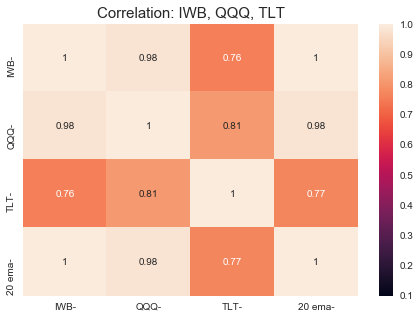

In [223]:
df3 = df1[['IWB','QQQ','TLT','20 ema']]
fig, ax = plt.subplots(1, 1, figsize=(7.5,5))
sns.heatmap(df3.corr(),vmin=0.1,vmax=1,annot=True)
ax.set_title('Correlation: IWB, QQQ, TLT', size=15)
ax.set_ylabel('')    
ax.set_xlabel('')

However, if we look at the correlation over the last four years between equities and bonds, it is drastically lower at 0.31, as seen in the graph below.

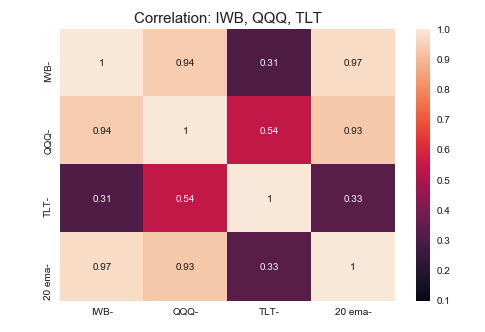

In [229]:
im = Image.open('CorrEqBd.PNG')
im

#### Calculate The Model

In [230]:
df1['model'] = 100*(1 + (df1['QQQ criteria'].shift(1)*df1['QQQ % change']) + (df1['TLT criteria'].shift(1))*(df1['TLT % change'])).cumprod()

#### Calculate The Model's Statistics

The backtest does not include trading commissions or fees. The returns are unlevered.

In [231]:
#Average yearly return
start_model = df1['model'].iloc[20]
end_model = df1['model'].iloc[-1]
years = (df1['model'].count()+1-20)/252

model_average_return = (end_model/start_model)**(1/years)-1
print('Model yields', model_average_return*100, '% per year')

#Maximum drawdown
df1['drawdown'] = (df1['model']/df1['model'].cummax()-1)*100
drawdown = df1['drawdown'].min()
print('Max Drawdown', drawdown)

Model yields 19.171432842205014 % per year
Max Drawdown -16.16045017505341


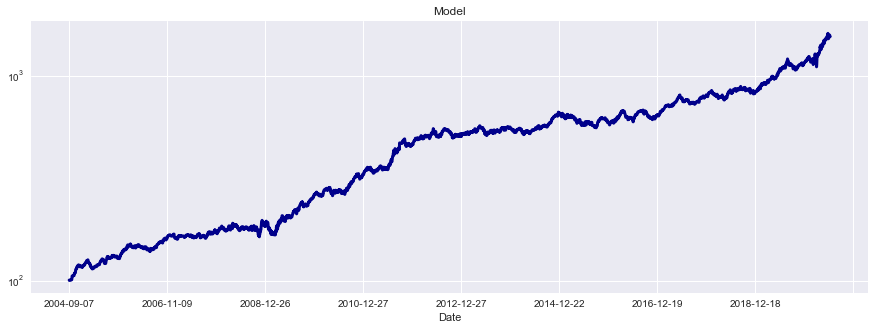

In [232]:
df1['model'].plot(kind='line', title='Model', logy=True, figsize=(15,5),c='darkblue',linewidth=3)

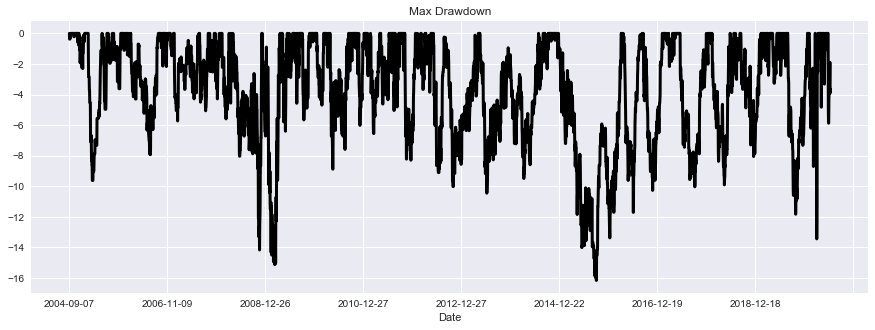

In [233]:
df1['drawdown'].plot(c='k',linewidth=3, title = 'Max Drawdown',figsize=(15,5))

In summary, identifying risk-on and risk-off environments to manage risk better is one of the most crucial aspects of investing. Reducing portfolio drawdowns will yield higher compounded returns over the investment life cycle. When the equity index weakens and trades below a particular moving average, we should pay attention. Finally, by timely shifting your weights for equities and bonds, it is possible to keep the maximum portfolio drawdown to less than half the Russell 1000 index during times of duress while generating double-digit returns year over year.

Good luck with the market! Guillaume, Fierce Research